[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)


# snnTorch - A Feedforward Spiking Neural Network
## Tutorial 3
### By Jason K. Eshraghian (www.ncg.ucsc.edu)
### 偏白话文翻译： manesec

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_3_feedforward_snn.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


snnTorch 教程系列基于以下论文。如果您发现这些资源或代码对您有帮助，请考虑引用以下来源：

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>


# 介绍

在本教程中，您将：

* 了解如何简化 带泄漏整合发放模型 (LIF) 神经元，使其适合深度学习
* 实现前馈尖峰神经网络（SNN）

单击以下单元格并按 “Shift+Enter”，安装 snnTorch 的最新 PyPi 发行版。

In [1]:
!pip install snntorch

In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

# 1. 简化带泄漏整合发放模型

在之前的教程中，我们设计了自己的 LIF 神经元模型。但它相当复杂，并且添加了一系列超参数来调整，包括 $R$、$C$、$\Delta t$、$U_{\rm thr}$，以及重置机制的选择。需要跟踪的内容有很多，而且当扩展到成熟的 SNN 时只会变得更加麻烦。所以让我们做一些简化。

## 1.1 衰减率: $\beta$

在之前的教程中，使用欧拉方法导出了被动膜模型的以下解：

$$U(t+\Delta t) = (1-\frac{\Delta t}{\tau})U(t) + \frac{\Delta t}{\tau} I_{\rm in}(t)R \tag{1}$$

现在假设没有电流输入，$I_{\rm in}(t)=0 A$：

$$U(t+\Delta t) = (1-\frac{\Delta t}{\tau})U(t) \tag{2}$$

令 $U$ 后续值的比率，即 $U(t+\Delta t)/U(t)$ 为膜电位的衰减率，也称为反时间常数：

$$U(t+\Delta t) = \beta U(t) \tag{3}$$

从 $(1)$ 来看，这意味着：

$$\beta = (1-\frac{\Delta t}{\tau}) \tag{4}$$

为了获得合理的精度，$\Delta t << \tau$。


## 1.2 加权输入电流

如果我们假设 $t$ 表示序列中的时间步长而不是连续时间，那么我们可以设置 $\Delta t = 1$。 为了进一步减少超参数的数量，假设 $R=1$。 根据 $(4)$，这些假设导致：

$$\beta = (1-\frac{1}{C}) \implies (1-\beta)I_{\rm in} = \frac{1}{\tau}I_{\rm in} \tag{5}$$

输入电流由 $(1-β)$ 加权。

另外假设输入电流瞬时对膜电位有贡献：

$$U[t+1] = \beta U[t] + (1-\beta)I_{\rm in}[t+1] \tag{6}$$

请注意，时间的离散化意味着我们假设每个时间段 $t$ 足够短，使得神经元在此间隔中最多只能发出一个尖峰。

在深度学习中，输入的权重因子通常是可学习的参数。 远离迄今为止所做的物理上可行的假设，我们将 $(6)$ 中 $(1-\beta)$ 的影响纳入可学习权重 $W$ 中，并将 $I_{\rm in}[t]$ 相应地带有输入 $X[t]$：


$$WX[t] = I_{\rm in}[t] \tag{7}$$

这可以用以下方式来解释。$X[t]$ 是输入电压或尖峰，与 $W$ 的突触电导成比例，向神经元注入电流。由此可得出以下结果：

$$U[t+1] = \beta U[t] + WX[t+1] \tag{8}$$


在未来的模拟中，$W$ 和 $\beta$ 的影响将被分离。 $W$ 是一个可学习的参数，其更新与 $\beta$ 无关。


## 1.3 尖峰和复位

现在我们来介绍一下尖峰和复位机制。回想一下，如果膜超过阈值，神经元就会发出输出尖峰：

$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases} \tag{9}$$

如果触发了尖峰，膜电位应该复位。*减弱复位* 机制的模型是：

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{S[t]U_{\rm thr}}_\text{reset} \tag{10}$$

由于 $W$ 是一个可学习的参数，而 $U_{\rm thr}$ 通常只是设置为 $1$（尽管可以调整），这就使得衰减率 $\beta$ 成为唯一需要指定的超参数。这就完成了本教程的痛苦部分。

> 注意：某些实现可能会做出略有不同的假设。例如，在 $(9)$ 中，$S[t] \rightarrow S[t+1]$，或在 $(10)$ 中，$X[t] \rightarrow X[t+1]$。上述推导正是 snnTorch 所使用的，因为我们发现它可以直观地映射到递归神经网络表示法，而性能不会有任何变化。

## 1.4 代码实现
在 Python 中实现这个神经元的过程如下：

In [4]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem

要设置 $\beta$ ，我们可以选择使用公式 $(3)$ 来定义，或者直接硬编码。在这里，为了演示，我们将使用公式 $(3)$，但在以后，我们将直接硬编码，因为我们更关注的是一些有效的东西，而不是生物精度。

等式 $(3)$ 告诉我们，$\beta$ 是随后两个时间步长的膜电位之比。使用 [教程 2](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)中推导出的方程的连续时变形式（假设没有电流注入）来求解：

$$U(t) = U_0e^{-\frac{t}{\tau}}$$

$U_0$ 是 $t=0$ 时的初始膜电位。假设随时间变化的方程是按 $t、（t+\Delta t）、（t+2\Delta t）~...~$ 的离散步骤计算的，那么我们可以用以下方法求出后续步骤之间的膜电位比：

$$\beta = \frac{U_0e^{-\frac{t+\Delta t}{\tau}}}{U_0e^{-\frac{t}{\tau}}} = \frac{U_0e^{-\frac{t + 2\Delta t}{\tau}}}{U_0e^{-\frac{t+\Delta t}{\tau}}} =~~...$$
$$\implies \beta = e^{-\frac{\Delta t}{\tau}} $$


In [5]:
# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)

print(f"The decay rate is: {beta:.3f}")

The decay rate is: 0.819


运行快速仿真，检查神经元对阶跃电压输入的响应是否正确：

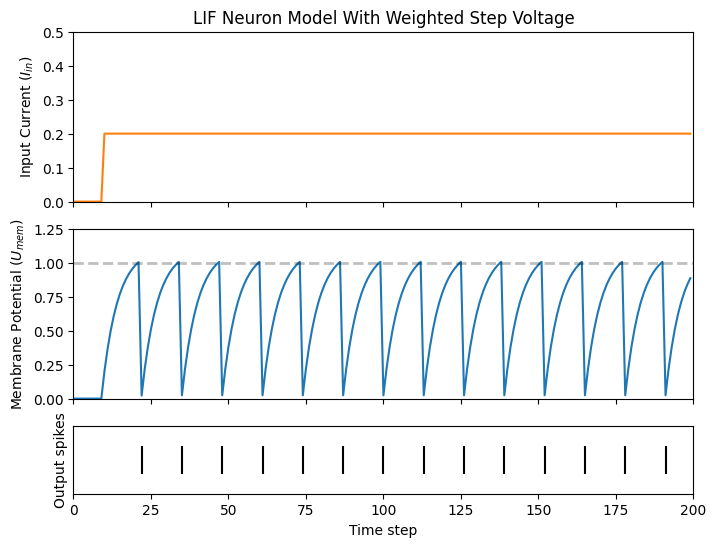

In [6]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

# 2. snnTorch 中的 `泄漏 Leaky` 神经元模型

通过实例化 `snn.Leaky`，我们可以得到一个几乎相同的神经元，这与我们在上一教程中使用 `snn.Lapicque` 的方法类似。但使用的超参数更少：

In [7]:
lif1 = snn.Leaky(beta=0.8)

神经元模型现在存储在 `lif1`中。要使用这个神经元

**输入**
* `cur_in`： $W\times X[t]$ 的每个元素都会作为输入依次传入
* `mem`：上一步膜电位 $U[t-1]$ 也作为输入传递。

**输出**
* `spk_out`：输出尖峰 $S[t]$（如果有尖峰，则为'1'；如果没有尖峰，则为'0'）
* `mem`：当前步骤的膜电位 $U[t]$

这些都需要是 `torch.Tensor` 类型。请注意，这里我们假定输入电流在进入 `snn.Leaky` 神经元之前已经加权。这在我们构建网络规模模型时会更有意义。此外，方程 $(10)$ 已在不失一般性的前提下向后移了一步。


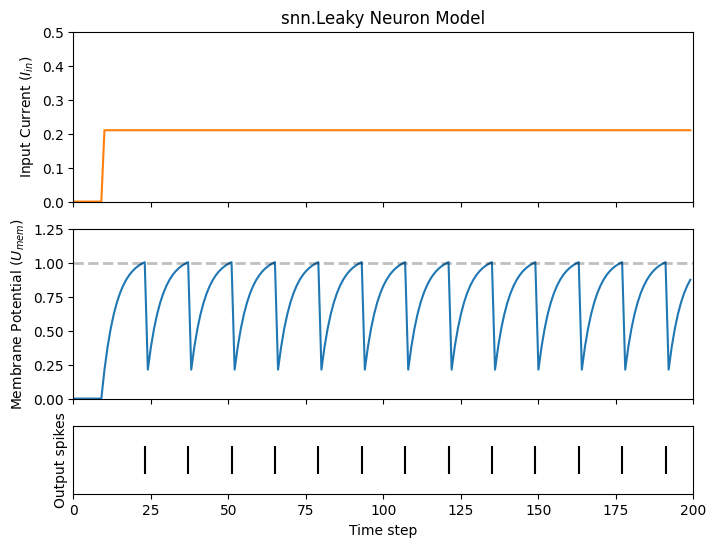

In [8]:
# Small step current input
w=0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")

将此图与手动推导的 "泄漏整合-发放" 神经元进行比较。膜电位复位稍弱：即使用*软复位*。这是有意为之，因为它能在一些深度学习基准测试中获得更好的性能。使用的等式是

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{\beta S[t]U_{\rm thr}}_\text{soft reset} \tag{11}$$


该模型具有与 Lapicque 神经元模型相同的 `复位机制` 和 `阈值` 可选输入参数。

# 3. 前馈尖峰神经网络

到目前为止，我们只考虑了单个神经元如何对输入刺激做出响应。snnTorch 可以直接将其扩展为深度神经网络。在本节中，我们将创建一个维数为 784-1000-10 的三层全连接神经网络。与迄今为止的模拟相比，现在每个神经元都将整合更多的输入尖峰。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_8_fcn.png?raw=true' width="600">
</center>

PyTorch 用于形成神经元之间的连接，而 snnTorch 则用于创建神经元。首先，初始化所有层。

In [9]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

接下来，初始化每个尖峰神经元的隐藏变量和输出。
随着网络规模的扩大，这项工作会变得越来越繁琐。好在一个静态方法 `init_leaky()` 可以解决这个问题。snnTorch 中的所有神经元都有自己的初始化方法，例如 `init_lapicque()`。在第一次前向传递时，隐藏状态的形状会根据输入数据的维度自动初始化。

In [10]:
# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

创建输入尖峰队列，并将其传递给网络。有 200 个时间步来模拟 784 个输入神经元，也就是说，输入的原始维度为 $200 \times 784$。snnTorch 使用时间优先维度：

[$时间 \times 批次大小 \times 维度$]

因此，输入的 `dim=1` 表示 "一批 "数据。这个输入张量的维数必须是 200 $\times$ 1 $\times$ 784：

In [11]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([200, 1, 784])


现在终于到了运行完整仿真的时候了。
关于 PyTorch 和 snnTorch 如何协同工作，一个直观的思路是 PyTorch 将神经元路由到一起，而 snnTorch 将结果加载到尖峰神经元模型中。在网络编码方面，这些尖峰神经元可以被视为时变激活函数。

下面是一个顺序说明：

* 从 `spk_in` 到 $j^{th}$ 神经元的 $i^{th}$ 输入由 `nn.Linear` 中初始化的参数加权：$X_{i} \times W_{ij}$
* 这将产生等式 $(10)$ 中的输入电流项，对尖峰神经元的 $U[t+1]$ 起作用。
* 如果 $U[t+1] > U_{\rm thr}$，那么该神经元将触发一个尖峰。
* 该尖峰由第二层权重加权，对所有输入、权重和神经元重复上述过程。
* 如果没有尖峰，则没有任何信息传递给突触后神经元。

与迄今为止的模拟唯一不同的是，我们现在是使用`nn.Linear`生成的权重来缩放输入电流，而不是自己手动设置 $W$。

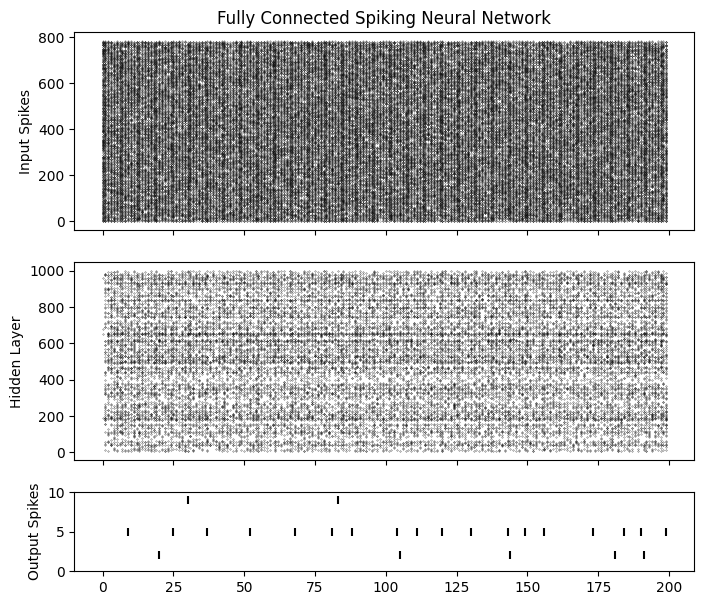

In [12]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

> 如果遇到错误，请尝试重新初始化网络和参数。

在这个阶段，尖峰没有任何实际意义。 输入和权重都是随机初始化的，并且没有进行任何训练。 但尖峰应该看起来是从第一层传播到输出。 如果您没有看到任何峰值，那么您可能在权重初始化抽签中不走运 - 您可能想尝试重新运行最后四个代码块。

`spikeplot.spike_count` 可以创建输出层的尖峰计数器。 下面的动画需要一些时间来生成。 <br>

> 注意：如果您在桌面上本地运行笔记本，请取消注释下面的行并修改 ffmpeg.exe 的路径

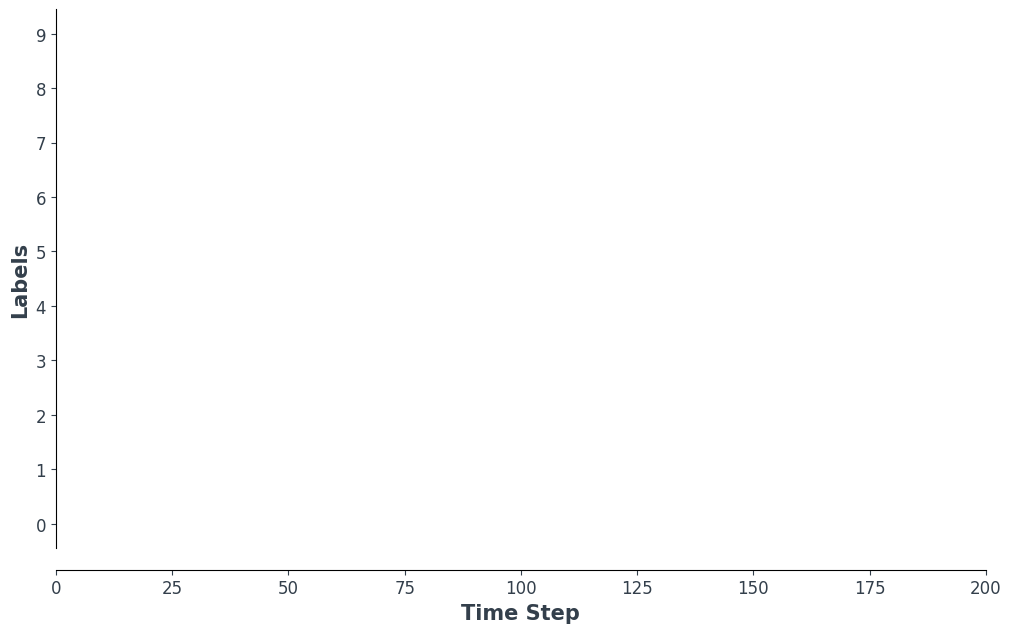

In [13]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

plt.rcParams['animation.ffmpeg_path'] = 'D:\\GoodApp\\ffmpeg\\bin\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

`spikeplot.traces` 可让您可视化膜电位轨迹。 我们将绘制 10 个输出神经元中的 9 个。 

将其与上面的动画和光栅图进行比较，看看是否可以将轨迹与神经元相匹配。

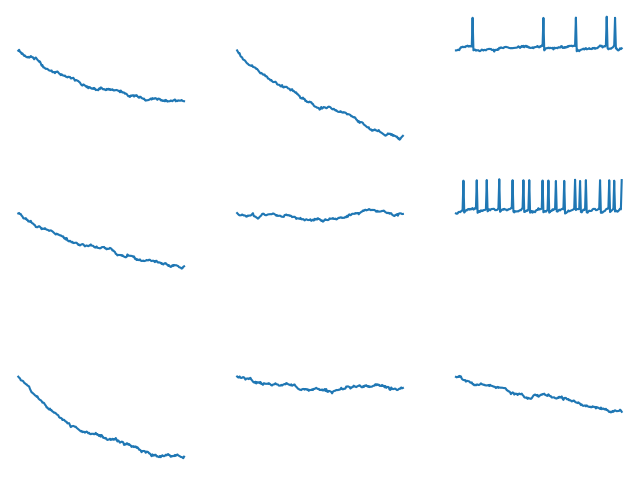

In [14]:
# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf()
fig.set_size_inches(8, 6)

如果一些神经元在放电而另一些神经元完全死亡，这是相当正常的。 同样，在训练权重之前，这些尖峰都没有任何实际意义。

# 结论

这涵盖了如何简化泄漏集成和激发神经元模型，然后使用它来构建尖峰神经网络。 在实践中，我们几乎总是更喜欢使用 `snn.Leaky` 而不是 `snn.Lapicque` 来训练网络，因为超参数搜索空间更小。

[教程 4](https://snntorch.readthedocs.io/en/latest/tutorials/index.html) 详细介绍了二阶 `snn.Synaptic` 和 `snn.Alpha` 模型。
接下来的教程对于训练网络来说不是必需的，因此如果您希望直接使用 snnTorch 进行深度学习，请跳到 [教程 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)。

作为参考，文档 [可以在此处找到](https://snntorch.readthedocs.io/en/latest/snntorch.html)。

如果您喜欢这个项目，请考虑为 GitHub 上的存储库加注星标，因为这是支持它的最简单、最好的方式。

## Further Reading
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [snnTorch documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html) of the Lapicque, Leaky, Synaptic, and Alpha models
* [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.
* [Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems](https://mitpress.mit.edu/books/theoretical-neuroscience) by Laurence F. Abbott and Peter Dayan